# FCT Unesp - TCC Treino 3v3
Aluno: Pétrus Antonio Bárbosa Pradella

TCC2 - Treinando análise preditiva para dados de transações comerciais.

Teste 3v2
    - DataSet Utilizado: Growth in Irish Whiskey Sales
    - Fonte:  Board Bia via The IWSR (2018)
    - Link: https://data.world/makeovermonday/2018w11-growth-in-irish-whiskey-sales
    
    Dataset disponibilizado no twitter da empresa "The IWSR" em 2018
    
Descrição da empresa:
   - "The global benchmark for beverage alcohol data and intelligence
We are the only company that measures country, category and brand performance through local market insight and analysis"
    
Caracteristicas gerais do Dataset:

    - Número de Instancias: 4131
    - Número de Atributos: 5
    
Anotações:
    - 1 "CASE" == 9 Litros

### Importando as bibliotecas necessárias

In [1]:
from myownapi.MainAPI import MainAPI;
import matplotlib.pyplot as plt;

### Carregando a base de dados

In [28]:
onlineMode = False;

if onlineMode:
    dataset_folder_url = "http://downloads.finalcraft.com.br/tcc/TimeSeries";
else:
    dataset_folder_url = "C:/Users/Petrus/Desktop/UNESP/Docs 2016-2020/2019/Segundo Semestre/TCC2/TCC BigData Analytics/Treino3";

dataset_file = dataset_folder_url + '/WhiskeySales.csv';

dataFrame = MainAPI.read_csv(dataset_file);
print("\n\n")
print(dataFrame)

Iniciando leitura do arquivo:
 --> C:/Users/Petrus/Desktop/UNESP/Docs 2016-2020/2019/Segundo Semestre/TCC2/TCC BigData Analytics/Treino3/WhiskeySales.csv
Arquivo lido com sucesso!



           Category        Quality        Country  Year      Cases
0     Irish Whiskey       Standard  United States  1990   243000.0
1     Irish Whiskey       Standard  United States  1991   214000.0
2     Irish Whiskey       Standard  United States  1992   219500.0
3     Irish Whiskey       Standard  United States  1993   225000.0
4     Irish Whiskey       Standard  United States  1994   239500.0
5     Irish Whiskey       Standard  United States  1995   249000.0
6     Irish Whiskey       Standard  United States  1996   259000.0
7     Irish Whiskey       Standard  United States  1997   279500.0
8     Irish Whiskey       Standard  United States  1998   296750.0
9     Irish Whiskey       Standard  United States  1999   322000.0
10    Irish Whiskey       Standard  United States  2000   343750.0
11    Irish W

### Descrevendo o DataFrame

In [16]:
MainAPI.descreverDataFrame()

Variáveis nulas foram encontradas!!
[Criando uma cópia do DataFrame sem as variáveis nulas]


,Category,Quality,Country,Cases
count,4131,4131,4131,2.794000e+03
unique,1,3,76,NaN
top,Irish Whiskey,Premium,DF Germany,NaN
freq,4131,1377,81,NaN
mean,NaN,NaN,NaN,3.509513e+04
std,NaN,NaN,NaN,1.421766e+05
min,NaN,NaN,NaN,0.000000e+00
20%,NaN,NaN,NaN,3.000000e+02
40%,NaN,NaN,NaN,2.000000e+03
50%,NaN,NaN,NaN,3.750000e+03


Um total de 1337 valores nulos foram encontrados.
O valor desses atributos nulos foram definidos para a média dos demais, no caso: 35095.134216177525


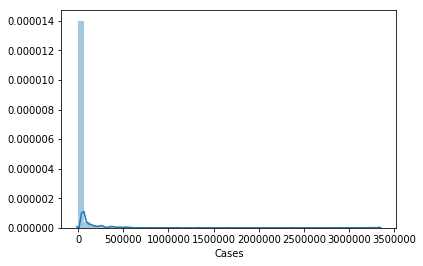

In [29]:
MainAPI.tratarVariaveisNulasComMediaDasOutras('Cases');
MainAPI.plotar('Cases')

### Selecionando dados 

In [30]:
import datetime

def yearToDate(year):
    return datetime.datetime(year,1,1);

MainAPI.df['Year'] = MainAPI.df['Year'].apply(yearToDate);

MainAPI.df['Year'].head(5)

0   1990-01-01
1   1991-01-01
2   1992-01-01
3   1993-01-01
4   1994-01-01
Name: Year, dtype: datetime64[ns]

In [31]:
MainAPI.arimaDefinirColunaObjetivo('Cases','Year')

In [32]:
MainAPI.df.head(5)

,Cases
Year,
1990-01-01,4.869188e+06
1991-01-01,4.915888e+06
1992-01-01,4.800407e+06
1993-01-01,4.754227e+06
1994-01-01,4.190724e+06


### Visualização dos Dados

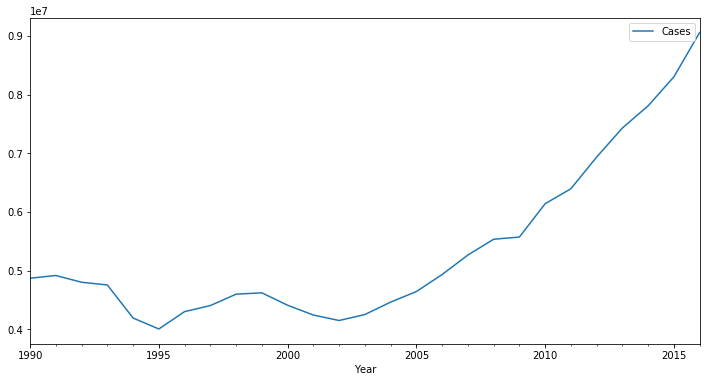

In [37]:
MainAPI.df.plot(figsize = (12,6))

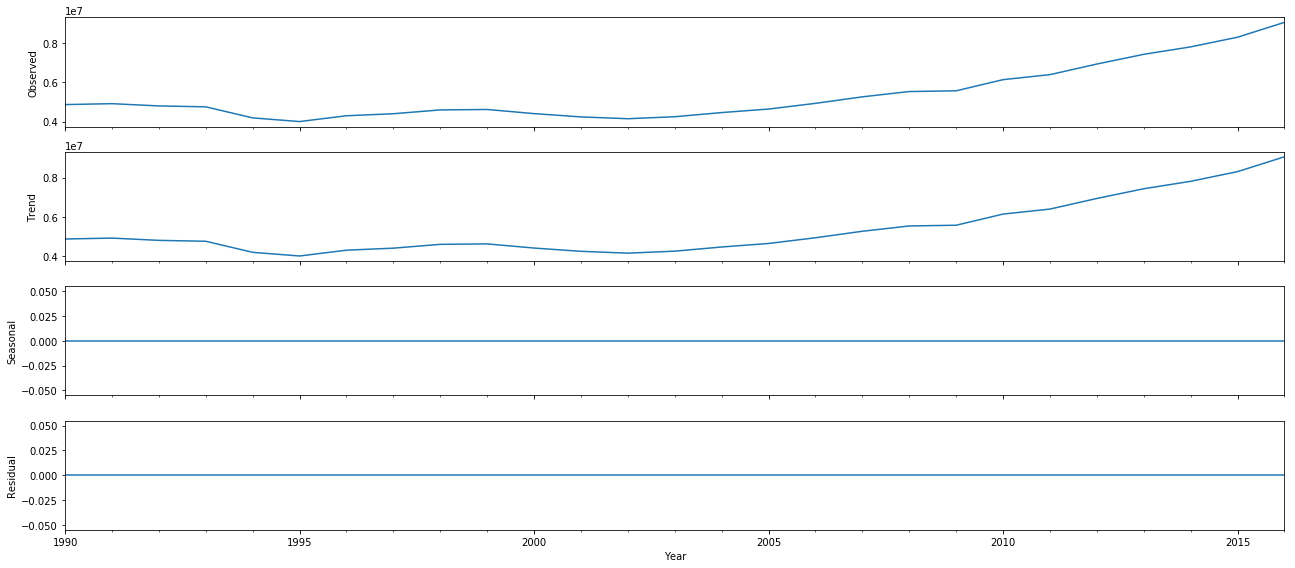

In [42]:
dataFrame = MainAPI.df;

from pylab import rcParams;
import statsmodels.api as sm;

rcParams['figure.figsize'] = 18,8;

#Dois tipos de modelos possíves, Aditivo e Multiplicativo (Necessário testar as diferenças)
decomposicao = sm.tsa.seasonal_decompose(dataFrame, model='addtive')
decomposicao.plot();


### Arima Predction


#### Preparando quantidade de treino.

In [43]:
import itertools;

p = sazonalidade = range(0, 2);     # Arima P == auto-regressive part of the model
d = tendencia = range(0, 2);        # Arima D == integrated part of the model
q = ruido = range(0,2);             # Arima Q == moving average part of the model

#itertools.product basicamente relaciona todas as variáveis com todas as varíaveis... como já diz, PRODUCT
pdq = list(itertools.product(sazonalidade, tendencia, ruido))

#Criando agora as variações de calculos para o arima usar.
#(Similar ao 'grid search' de machine learning)
ARIMA_SASONALIDADE = 1; #1 ano;
seasonal_pdq = [(x[0], x[1], x[2], ARIMA_SASONALIDADE) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 1),
 (0, 0, 1, 1),
 (0, 1, 0, 1),
 (0, 1, 1, 1),
 (1, 0, 0, 1),
 (1, 0, 1, 1),
 (1, 1, 0, 1),
 (1, 1, 1, 1)]

#### Escolhendo melhor combinação de parametros arima

In [44]:
import warnings;
import sys;
warnings.filterwarnings("ignore") # Negócio chato pacas...

menorCombinacao = None;
menorCombinacaoValor = 99999999999999999;#Mesma coisa que Integer.MAX_VALUE

for parametro in pdq:
    for parametro_sasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dataFrame,
                                            order=parametro,
                                            seasonal_order=parametro_sasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            resultado = mod.fit()
            
            if resultado.aic < menorCombinacaoValor:
                menorCombinacao = [parametro, parametro_sasonal, ARIMA_SASONALIDADE];
                menorCombinacaoValor = resultado.aic;
            
            print('ARIMA{}x{}x{} - AIC:{}'.format(parametro, parametro_sasonal, ARIMA_SASONALIDADE, resultado.aic))
        except:
            #Algumas combinações são NaN (Não são possíveis! por isso tem esse TryCath)
            continue
          
print('\n\n')
print('O menor valor encontrado par ao AIC é: {}'.format(menorCombinacaoValor))
print('Utilizando a combinação: ARIMA{}x{}x{}'.format(menorCombinacao[0], menorCombinacao[1], menorCombinacao[2]))

theOrder = menorCombinacao[0];
theSeasonal_order = menorCombinacao[1];

ARIMA(0, 0, 0)x(0, 0, 0, 1)x1 - AIC:883.458630465093
ARIMA(0, 0, 0)x(0, 0, 1, 1)x1 - AIC:835.0204256397393
ARIMA(0, 0, 0)x(0, 1, 0, 1)x1 - AIC:709.2826999610885
ARIMA(0, 0, 0)x(0, 1, 1, 1)x1 - AIC:675.0956291571007
ARIMA(0, 0, 0)x(1, 0, 0, 1)x1 - AIC:726.6978144867396
ARIMA(0, 0, 0)x(1, 0, 1, 1)x1 - AIC:695.5888371264716
ARIMA(0, 0, 0)x(1, 1, 0, 1)x1 - AIC:693.5993495726735
ARIMA(0, 0, 0)x(1, 1, 1, 1)x1 - AIC:667.93142436927
ARIMA(0, 0, 1)x(0, 0, 0, 1)x1 - AIC:835.0204256397393
ARIMA(0, 0, 1)x(0, 0, 1, 1)x1 - AIC:800.9196837158929
ARIMA(0, 0, 1)x(0, 1, 0, 1)x1 - AIC:675.0956291571007
ARIMA(0, 0, 1)x(0, 1, 1, 1)x1 - AIC:648.8038608750043
ARIMA(0, 0, 1)x(1, 0, 0, 1)x1 - AIC:829.432036361587
ARIMA(0, 0, 1)x(1, 0, 1, 1)x1 - AIC:798.493624035973
ARIMA(0, 0, 1)x(1, 1, 0, 1)x1 - AIC:671.226927264627
ARIMA(0, 0, 1)x(1, 1, 1, 1)x1 - AIC:645.9106241804943
ARIMA(0, 1, 0)x(0, 0, 0, 1)x1 - AIC:709.2826999610885
ARIMA(0, 1, 0)x(0, 0, 1, 1)x1 - AIC:675.0956291571007
ARIMA(0, 1, 0)x(0, 1, 0, 1)x1 - AI

#### Ajuste de Modelo

In [45]:
mod = sm.tsa.statespace.SARIMAX(dataFrame,
                                order=theOrder,
                                seasonal_order=theSeasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

resultado_final = mod.fit()

print(resultado_final.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0333      1.501     -0.022      0.982      -2.975       2.909
ma.L1         -0.6016      0.098     -6.115      0.000      -0.794      -0.409
ma.S.L1        0.2483      1.314      0.189      0.850      -2.326       2.823
sigma2      4.581e+10   4.48e-11   1.02e+21      0.000    4.58e+10    4.58e+10


### Forecast dos dados em modo de treino

In [48]:
import pandas as pd;

#Predição propriamente dita
pred = resultado_final.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
pred_ci = pred.conf_int()

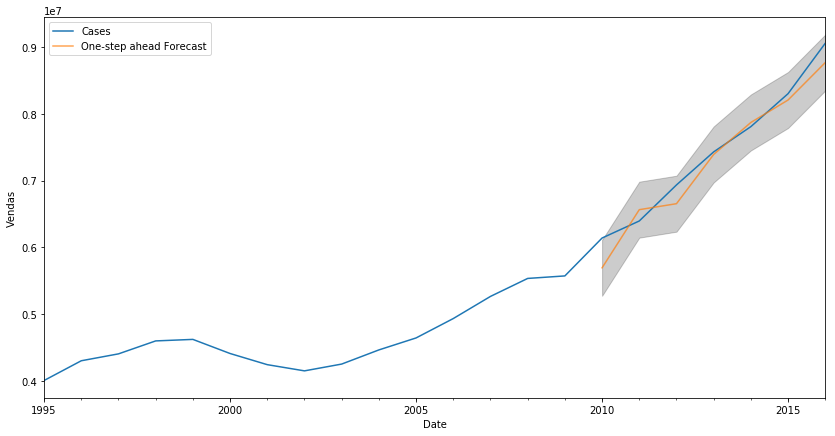

In [50]:
import matplotlib.pyplot as plt

ax = dataFrame['1995':].plot(label='Observado')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14,7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Vendas')
plt.legend()
plt.show()


### Real Forecast

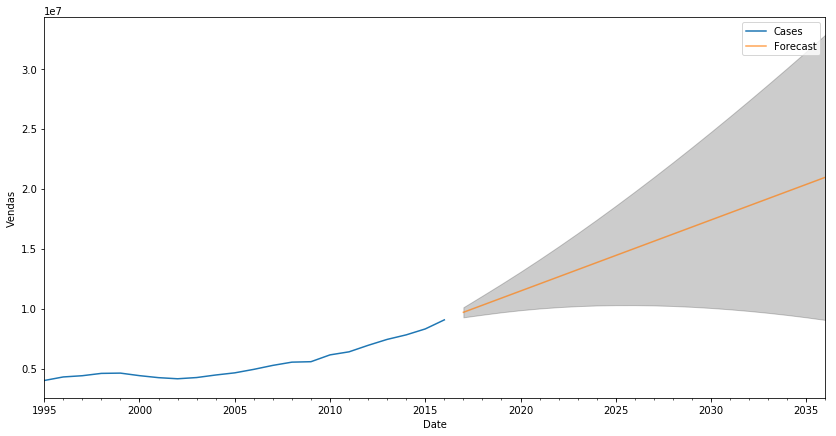

In [53]:
pred_uc = resultado_final.get_forecast(steps=20)
pred_ci = pred_uc.conf_int()

ax = dataFrame['1995':].plot(label='Observado')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14,7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Vendas')
plt.legend()
plt.show()